In [1]:
# %reset
# Para visualización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import pylab
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

# Archivos
import urllib.request
import glob

# Análisis de sonido
import spotipy 

# Machine learning
# importar los paquetes para clustering
from sklearn.preprocessing import StandardScaler

# To work with categorical types
from pandas.api.types import CategoricalDtype

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics.pairwise import euclidean_distances

from funciones import plot_silhouette
from funciones import plot_silhouettes_and_sses
from funciones import get_silhouette_avg
from funciones import get_sse
from funciones import vanDongen

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE

from umap import UMAP

Para realizar un clustering espectral, se toman los resultados de aplicarle UMAP al dataset y luego, al resultado, se le aplica KMeans.

In [2]:
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()

In [3]:
metadata = pd.read_csv('../data/metadata.csv', index_col='id')
audio_features = pd.read_csv('../data/audio_features.csv', index_col='id')
audio_analysis = pd.read_csv('../data/audio_analysis.csv', index_col='id')

audio_features = audio_features[['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness','loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

# Para que las comparaciones sean del mismo largo,
# se remueve de audio_feature y metadata el track que no se encuentra en audio_analysis
merged = audio_features.merge(audio_analysis, how = 'left', on = 'id')
id_to_remove = merged[merged.timbre_mean_0.isnull()].index[0]

audio_features = audio_features.drop(id_to_remove, axis = 0)

audio_tracks = pd.merge(audio_features, audio_analysis, how = 'inner', on = 'id')
metadata = metadata.drop(id_to_remove, axis = 0)

# Se ordenan los datasets para que los tracks estén en el mismo orden
audio_features = audio_features.sort_index()
audio_analysis = audio_analysis.sort_index()
audio_tracks = audio_tracks.sort_index()
metadata = metadata.sort_index()

audio_features_norm = scaler.fit_transform(audio_features)
audio_analysis_norm = scaler.fit_transform(audio_analysis)
audio_tracks_norm = scaler.fit_transform(audio_tracks)

In [7]:
genres = []
for genre in metadata.genre:
    if genre == 'ambient':
        genres.append(0)
    if genre == 'classical':
        genres.append(1)
    if genre == 'drum-and-bass':
        genres.append(2)
    if genre == 'jazz':
        genres.append(3)
    if genre == 'world-music':
        genres.append(4)
len(genres)

2205

# audio_features

In [10]:
# Se le aplica UMAP al audio_features_norm
um = UMAP()
embedding = um.fit_transform(audio_features_norm)
embedding.shape

/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


(2205, 2)

Se busca un k óptimo para clusterizar las 2 dimensiones obtenidas con UMAP.

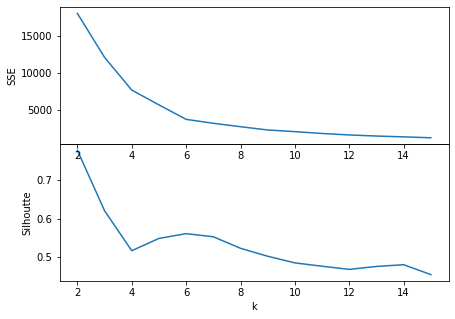

In [11]:
plot_silhouettes_and_sses(embedding, 15)

Parece que se tiene un buen tradeoff con k = 6, que es donde el SSE toma la forma de codo y el silhouette levanta por sobre 0.5.

In [14]:
get_silhouette_avg(embedding, 6)

0.5612561

In [17]:
get_sse(embedding, 6)

3691.8312486625555

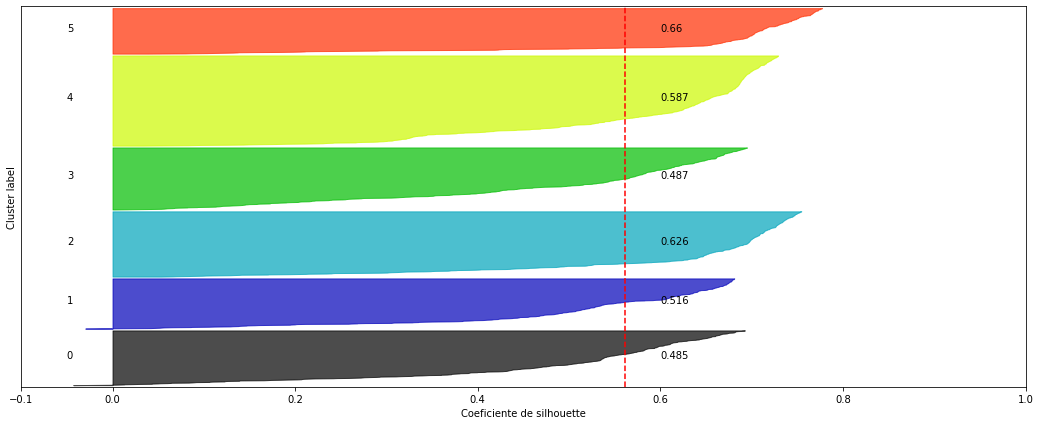

In [20]:
plot_silhouette(embedding, 6)

Se evalua qué tan buenos son los agrupamientos obtenidos.

In [37]:
km_audio_features = KMeans(n_clusters = 6, random_state = 0).fit(embedding)

In [38]:
# Se calcula la matriz de confusión
tmp1 = pd.DataFrame({'Generos': metadata.genre, 'audio_features': km_audio_features.labels_})
ct1 = pd.crosstab(tmp1['Generos'], tmp1['audio_features'])
ct1

audio_features,0,1,2,3,4,5
Generos,,,,,,
ambient,44,34,154,25,193,10
classical,0,0,126,60,192,27
drum-and-bass,225,220,0,4,0,2
jazz,18,16,72,133,90,97
world-music,41,31,39,150,65,137


In [39]:
vanDongen(ct1)

0.715585559142941

In [40]:
adjusted_rand_score(metadata.genre, km_audio_features.labels_)

0.18661794356430217

# Hiperparametrización

UMAP tiene varios hiperparámetros para probar. En esta hiperparametrización, probaremos haciendo un grid search con 4 paramétros:

 * n_neighbors
 * min_dist
 * n_components
 * metrics

In [55]:
columns = ['Dataset', 'Metric', 'Scaler',
           'n_components', 'min_dist', 'n_neighbors',
           'k', 'silhoutte', 'sse', 'vanDongen', 'adjRand']
results = []

n_neighbors = [2, 5, 10, 20, 50, 100, 200]

min_dist = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]

n_components = range(2, 16)

#metrics = ["euclidean", "manhattan", "minkowski", "canberra", "mahalanobis", "cosine", "correlation"]

metrics = ["euclidean"]

datasets = {
    "audio_features": audio_features,
    "audio_analysis": audio_analysis,
    "audio_tracks": audio_tracks
}

scalers = {
    "minMax": MinMaxScaler(feature_range=(0,1)),
    "standard": StandardScaler()
}

ks = range(2, 16)

for dataset in datasets.keys():
    for metric in metrics:
        for scaler in scalers.keys():
            for components in n_components:
                for neighbors in n_neighbors:
                    for min_d in min_dist:
                        for k in ks:
                            
                            print(dataset + ', ' + metric + ', ' + scaler + ', n_components=' + str(components) + ', n_neighbors=' + str(neighbors) + ', min_dist=' + str(min_d) + ', k=' + str(k))

                            # Se estandariza usando el scaler correspondiente
                            df = scalers[scaler].fit_transform(datasets[dataset])
                            
                            # Se aplica UMAP
                            um = UMAP(n_components = components, n_neighbors = neighbors, min_dist = min_d, metric = metric)
                            embedding = um.fit_transform(df)
                            
                            # Se calculan las validaciones internas
                            sil = get_silhouette_avg(embedding, k)
                            sse = get_sse(embedding, k)
                            
                            # Se aplica KMeans
                            km = KMeans(n_clusters = k, random_state = 0).fit(embedding)
                            
                            # Se calcula la matriz de confusión
                            tmp = pd.DataFrame({'Generos': metadata.genre, 'data': km.labels_})
                            ct = pd.crosstab(tmp['Generos'], tmp['data'])
                            
                            # Se calculan las validaciones externas
                            vd = vanDongen(ct)
                            rand = adjusted_rand_score(metadata.genre, km.labels_)
                            
                            # Se guardan los resultados de la corrida
                            results.append([dataset, metric, scaler,
                                           components, min_d, neighbors,
                                           k, sil, sse, vd, rand])

df_results = pd.DataFrame(results, columns = columns)
df_results

audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=2


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=3


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=4


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=5


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=6


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=7


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=8


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=9


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=10


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=11


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=12


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=13


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=14


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


audio_features, euclidean, minMax, n_components=2, n_neighbors=10, min_dist=0.25, k=15


/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


,Dataset,Metric,Scaler,n_components,min_dist,n_neighbors,k,silhoutte,sse,vanDongen,adjRand
0,audio_features,euclidean,minMax,2,0.25,10,2,0.749352,22655.269363,0.993050,0.001535
1,audio_features,euclidean,minMax,2,0.25,10,3,0.583202,15508.924388,0.904907,0.064889
2,audio_features,euclidean,minMax,2,0.25,10,4,0.469650,10949.427257,0.801633,0.104172
3,audio_features,euclidean,minMax,2,0.25,10,5,0.473585,8574.716143,0.752493,0.135111
4,audio_features,euclidean,minMax,2,0.25,10,6,0.520315,5839.592675,0.710094,0.188605
5,audio_features,euclidean,minMax,2,0.25,10,7,0.513632,4912.091610,0.733783,0.160797
6,audio_features,euclidean,minMax,2,0.25,10,8,0.462284,4232.394135,0.708484,0.163070
7,audio_features,euclidean,minMax,2,0.25,10,9,0.469260,3614.178637,0.714524,0.162813
8,audio_features,euclidean,minMax,2,0.25,10,10,0.463677,3185.600330,0.768140,0.127069
9,audio_features,euclidean,minMax,2,0.25,10,11,0.436812,2814.818457,0.720011,0.144542


In [56]:
df_results.to_csv('espectral.csv', index = False)